# SVM: Kernel RBF
M2U5 - Ejercicio 11

## ¿Qué vamos a hacer?
- Generar un dataset sintético de 2 clases (binario)
- Preprocesar el dataset
- Entrenar un modelo de clasificación por SVM sobre el mismo
- Comprobar su idoneidad
- Optimizar los hiper-parámetros de nuestro modelo por validación
- Evaluar nuestro modelo

Recuerda seguir las instrucciones para las entregas de prácticas indicadas en [Instrucciones entregas](https://github.com/Tokio-School/Machine-Learning/blob/main/Instrucciones%20entregas.md).

## Instrucciones
Del mismo modo que habíamos hecho para la clasificación por regresión logística usando Scikit-learn, ahora vamos a usarlo para resolver problemas de clasificación por SVM.

En concreto, vamos a usar su clasificador SVC con el kernel RBF ("Radial Basis Function"). El modelo SVC de Scikit-learn tiene varios kernels disponibles, y el kernel gaussiano en concreto no está entre ellos. Sin embargo, el kernel RBF está muy relacionado con él puesto que también parte de una clasificación "radial", y en proyectos reales puede ser más eficiente y tener más rendimiento que el gaussiano.

Por ello, en lugar del kernel gaussiano usaremos el RBF.

Este kernel de SVM tiene 2 parámetros:
- *C*: La inversa del parámetro de regularización. Para valores mayores de *C*, se aceptará un margen entre clases menor si la función de decisión clasifica mejor los ejemplos de entrenamiento. Valores menores de *C* intentarán incrementar el margen entre clases, con una función de decisión más simple por lo tanto, con la posible desventaja de una menor precisión.
- *Gamma*: Define lo lejos que llega la influencia de cada ejemplo, o la inversa del radio de influencia de los ejemplos seleccionados por el modelo como "landmarks". Valores menores significarán una influencia con mayor alcance y valores mayores una influencia mucho más cercana.

Vamos a optimizar ambos parámetros usando validación cruzada.

Como referencia para este ejercicio puedes usar estos enlaces de la documentación:
- [SVM: Classification](https://scikit-learn.org/stable/modules/svm.html#classification)
- [skelarn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [RBF SVM parameters](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html)
- [SVM: Maximum margin separating hyperplane](https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html)
- [Non-linear SVM](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_nonlinear.html)

In [1]:
# TODO: Importa todos los módulos necesarios en esta celda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import GridSearchCV



## Crear un dataset sintético de clasificación binaria

Crea un dataset para clasificación de 2 clases con [sklearn.datasets.make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html).

Recuerda usar parámetros que luego podamos modificar como el nº de ejemplos, características y clases, si queremos que esté desordenado o no, un estado aleatorio inicial constante, nº de clústeres, etc.:

In [2]:
# TODO: Crea un dataset sintético para clasificación binaria

# Parámetros configurables
n_samples = 200
n_features = 2
n_informative = 2
n_redundant = 0
n_classes = 2
n_clusters_per_class = 1
flip_y = 0.05
class_sep = 1.0
random_state = 42


X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=n_redundant,
    n_classes=n_classes,
    n_clusters_per_class=n_clusters_per_class,
    flip_y=flip_y,
    class_sep=class_sep,
    random_state=random_state)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (200, 2)
y shape: (200,)


## Preprocesar los datos

Preprocesa los datos:


In [3]:
# TODO: Reordena los datos aleatoriamente, normaliza y divide en entrenamiento, test y CV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Entrena un modelo de clasificación por SVM inicial

Para comprobar el funcionamiento de nuestro clasificador SVC antes de optimizarlo por validación cruzada, vamos a entrenar un modelo inicial sobre el subset de entrenamiento y validarlo sobre el subset de test.

Recuerda usar la función [decision_function_shape](https://scikit-learn.org/stable/modules/svm.html#multi-class-classification) para usar el esquema "uno contra el resto" (OVR).

Usa los valores por defecto de *C* y *gamma* para no influir sobre su regularización:

In [12]:
# TODO: Entrena un modelo de SVC sin modificar los parámetros de regularización sobre el subset de entrenamiento
svc = SVC(kernel="rbf", decision_function_shape="ovr", C=1.0, gamma="scale")
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [11]:
# TODO: Evalúa el modelo con su model.score() sobre el subset de test
accuracy = svc.score(X_test, y_test)
print("Precisión:", accuracy)

Precisión: 0.775


Una forma muy gráfica de comprender mejor cómo trabajan los SVM y comprobar la precisión de tu modelo es representar el hiper-plano que ahora separa las clases, cuyo margen con las clases intentamos maximizar.

Para representarlo, recuerda que puedes seguir el ejemplo de [SVM: Maximum margin separating hyperplane](https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html) y modificar su código:

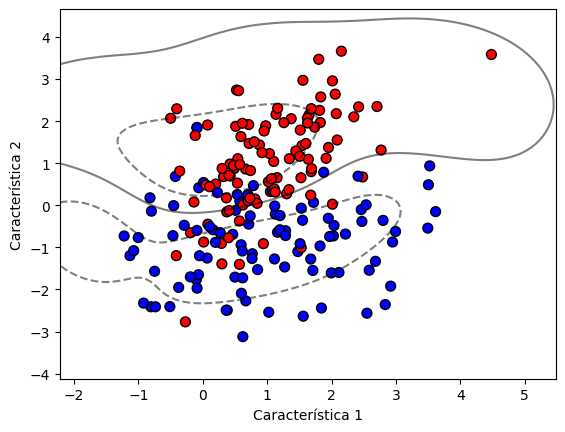

In [13]:
# TODO: Representa gráficamente el hiper-plano de separación con el margen de clases
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr", edgecolor="k", s=50)

ax = plt.gca()

DecisionBoundaryDisplay.from_estimator(
    svc,
    X,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax)

plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.show()

## Optimizar los hiper-parámetros de regularización por validación cruzada

Ahora vamos a usar de nuevo [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) para optimizar nuestros hiper-parámetros *C* y *gamma* por K-fold a la vez en esta ocasión, y representar sus posibles valores de forma visual.

Un ejemplo para ello muy interesante como hemos refernciado es [RBF SVM parameters](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html).

Modifica su código para optimizar nuestro modelo sobre nuestro dataset sintético usando K-fold para optimizar *C* y *gamma*. Puedes usar el mismo rango logarítmico de valores para estos hiper-parámetros o adecuarlo a este dataset.

*Nota*: Recuerda que hemos preprocesado el dataset previamente siguiendo nuestros métodos habituales.

In [7]:
# TODO: Optimiza los hiper-parámetros de SVC
C_range =[0.1, 1, 10, 100, 1000, 10000, 10000]
gamma_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(gamma=gamma_range, C=C_range)

grid_search = GridSearchCV(
    estimator= svc,
    param_grid= param_grid,
    scoring= "accuracy",
    cv=5)
grid_search.fit(X_train, y_train)
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor accuracy:", grid_search.best_score_)

Mejores hiperparámetros: {'C': 10000, 'gamma': 0.01}
Mejor accuracy: 0.8625


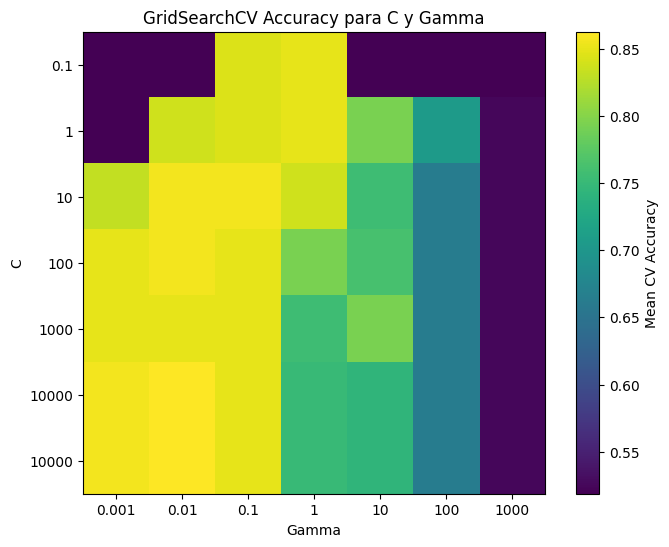

In [8]:
# TODO: Representa los efectos de los parámetros
scores = grid_search.cv_results_["mean_test_score"].reshape(len(param_grid["C"]), len(param_grid["gamma"]))

plt.figure(figsize=(8,6))
plt.imshow(scores, interpolation= "nearest", cmap= "viridis")
plt.xlabel("Gamma")
plt.ylabel("C")
plt.colorbar(label= "Mean CV Accuracy")
plt.xticks(np.arange(len(param_grid["gamma"])), param_grid["gamma"])
plt.yticks(np.arange(len(param_grid["C"])), param_grid["C"])
plt.title("GridSearchCV Accuracy para C y Gamma")
plt.show()

El SVM tiene un valor C muy grande y gamma muy pequeño produce una frontera amplia que clasifica la mayoría de puntos correctamente, alcanzando un 87.5% de precisión.

## Evaluar el modelo finalmente sobre el subset de test
- Muestra los coeficientes e intercept del mejor modelo.
- Evalúa el mejor modelo sobre el subset de test inicial.
- Representa las predicciones de las clases para comprobar los aciertos, fallos y el margen entre clases en el nuevo hiper-plano.

Para representar las predicciones y el hiper-plano de margen entre clases, puedes volver a usar el código con el que evaluaste el modelo inicial:

In [16]:
# TODO: Evalúa el mejor modelo sobre el subset de test inicial
mejor_svc = grid_search.best_estimator_
print("Intercept:", mejor_svc.intercept_)
print("Número de vectores de soporte:", len(mejor_svc.support_vectors_))

test_accuracy = mejor_svc.score(X_test, y_test)
print("Precisión en test:", test_accuracy)

Intercept: [-10.4274691]
Número de vectores de soporte: 53
Precisión en test: 0.775


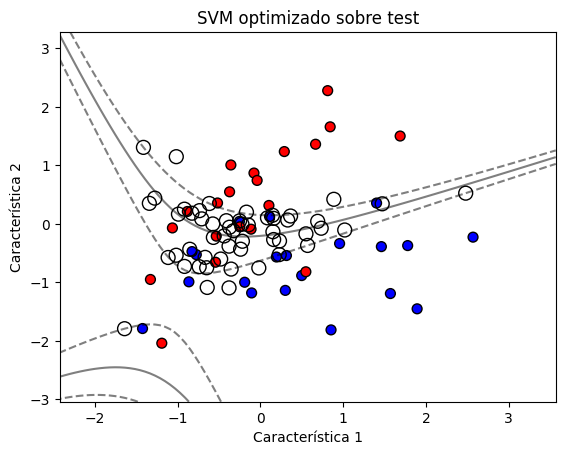

In [14]:
# TODO: Representa las predicciones, comprueba la precisión y el margen entre clases
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="bwr", edgecolor="k", s=50)

ax = plt.gca()

DecisionBoundaryDisplay.from_estimator(
    mejor_svc,
    X_test,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
    alpha=0.5,
    ax=ax)

# Vectores de soporte
ax.scatter(
    mejor_svc.support_vectors_[:, 0],
    mejor_svc.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",)

plt.title("SVM optimizado sobre test")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.show()